In [97]:
import re, time, warnings, os, sys, copy
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import aux, data, rsa
sys.path.append('../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

## Supplementary Figure 9 & Table 9
This notebook produces supplementary results regarding stimulus properties.

In [98]:
# load embedding
G = emb.glove.load_embedding(f_in = './data/preprocessed/misc/glove/w2v_50D.txt')

# load sample data
sub = data.Subjects['0002']
sid, pid = sub.sid, sub.pid
df = pd.read_csv(f'./data/raw/beh/sub{sid}/{pid}.csv')
df = df.loc[(df.type == data.defs.TRIAL_MT_MAIN)].reset_index(drop = True)

# grab words & contexts
words = np.array(df.options_0.tolist())
contexts = np.array(df.context.tolist())
embeddings = np.array([G[word.lower()] for word in words])

from sklearn.decomposition import PCA

# fit pca
pca = PCA(n_components = 2).fit(embeddings)
X_w = pca.transform(embeddings)
X_mu, X_sigma = X_w.mean(axis = 0), X_w.std(axis = 0)
X_w = (X_w - X_mu) / X_sigma

# load kappa data
M = pd.read_excel('./data/preprocessed/misc/stimulus/pairs.xlsx')
kappa = []
for k in M.f1_k.tolist(): kappa.append(k)
for k in M.f2_k.tolist(): kappa.append(k)
for k in M.f1_k.tolist(): kappa.append(-k)
for k in M.f2_k.tolist(): kappa.append(-k)
kappa = np.array(kappa)
k_contexts = np.array(M.context1.tolist() + M.context1.tolist() + M.context2.tolist() + M.context2.tolist())

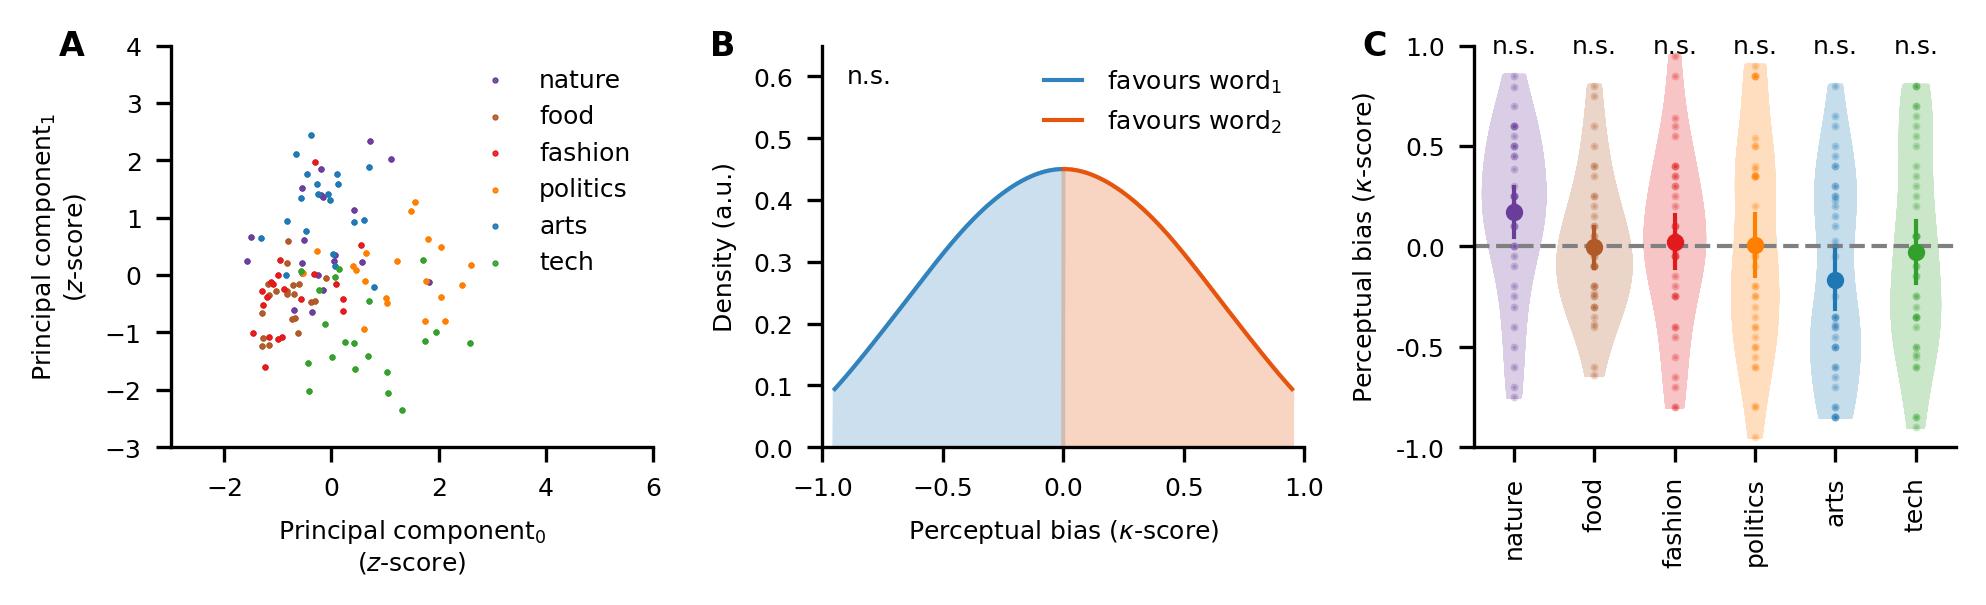

In [100]:
'''
Create the figure
'''

C_s = pub.colours.equidistant('Paired', k = 12)
C = pub.colours.equidistant('tab20c', k = 20)

context_labels = dict(outdoor = 'nature', essen = 'food', fashion = 'fashion',
                      politik = 'politics', unterhaltung = 'arts', technik = 'tech')
order = np.array(['outdoor', 'essen', 'fashion', 'politik', 'unterhaltung', 'technik'])

colours = dict(outdoor = C_s[9], essen = C_s[11], fashion = C_s[5], 
               politik = C_s[7], unterhaltung = C_s[1], technik = C_s[3])

fig, ax = pub.figure(nrows = 1, ncols = 3)

# add semantic embeddings of words
for i, context in enumerate(context_labels):
    indc = np.where(contexts == context)[0]
    
    ax[0].scatter(X_w[indc,0], X_w[indc,1], color = colours[context], marker = '.', s = 1, label = context_labels[context])

ax[0].set_ylim([-3, 4])
ax[0].set_xlim([-3, 6])
ax[0].set_xlabel(r'Principal component$_0$' + '\n' + r'($z$-score)')
ax[0].set_ylabel(r'Principal component$_1$' + '\n' + r'($z$-score)')
pub.cosmetics.legend(ax = ax[0], loc = 'upper right')

# add kappa overall
test = scipy.stats.ttest_1samp(kappa, 0, alternative = 'two-sided')

bw = pub.dist._bandwidth_botev(kappa)
h = pub.dist.icebergs(kappa, 
                      kernel_bandwidth = bw, density_theta = 0,
                      splits = dict(critvalue = 0, lb_color = C[0], ub_color = C[4], lb_label = r'favours word$_1$', ub_label = r'favours word$_2$'),
                      ax = ax[1])
ax[1].set_ylim([0, 0.65])
ax[1].set_xlim([-1, 1])
ax[1].set_ylabel(r'Density (a.u.)')
ax[1].set_xlabel(r'Perceptual bias ($\kappa$-score)')
ax[1].annotate(pub.significance.__sig_from_p(test.pvalue), xy = (-0.95, 0.55), xytext = (-0.9, 0.6), ha = 'left', va = 'center')
pub.cosmetics.legend(ax = ax[1], loc = 'upper right', handles = h)

# add kappa by context
Xs = np.zeros((6, 40))
labels = []
labs = []

for i, context in enumerate(context_labels):
    indc = np.where(k_contexts == context)[0]
    Xs[i,:] = kappa[indc]
    labels.append(context)
    labs.append(context_labels[context])
    
    pv = np.clip(scipy.stats.ttest_1samp(kappa[indc], popmean = 0.0).pvalue * 6, 0, 1)
    ax[2].annotate(pub.significance.__sig_from_p(pv), xy = (i, 1.0), xytext = (i, 1.0), ha = 'center', va = 'center', annotation_clip = False)

ax[2].plot([-0.5, 5.5], [0, 0], color = 'gray', linestyle = '--')
pub.dist.violins(Xs, colours = [colours[labels[0]], colours[labels[1]], colours[labels[2]],
                                colours[labels[3]], colours[labels[4]], colours[labels[5]]], scatter_dep = False, kernel_bandwidth = bw, ax = ax[2])
ax[2].set_ylim([-1, 1])
ax[2].set_ylabel(r'Perceptual bias ($\kappa$-score)')
ax[2].set_yticks(np.arange(-1, 1.01, 0.5), labels = np.round(np.arange(-1, 1.01, 0.5), 1))
ax[2].set_xlim([-0.5, 5.5])
ax[2].set_xticks(np.arange(6), labels = labs, rotation = 90)

pub.cosmetics.figlabels(['A'], ax = ax[0])
pub.cosmetics.figlabels(['B'], ax = ax[1])
pub.cosmetics.figlabels(['C'], ax = ax[2])

pub.cosmetics.finish()

fig.savefig(f'./figures/png/suppfig9_stimulus.png', dpi = 300)
fig.savefig(f'./figures/svg/suppfig9_stimulus.svg')
fig.savefig(f'./figures/pdf/suppfig9_stimulus.pdf')

In [94]:
'''
Create the table
'''

w_a, w_b = np.array(df.options_0.tolist()), np.array(df.options_1.tolist())

pairs = []
cs = []

for i, (w_ai, w_bi) in enumerate(zip(w_a, w_b)):
    pair_a = f'{w_ai}-{w_bi}'
    pair_b = f'{w_bi}-{w_ai}'
    if (pair_a in pairs) or (pair_b in pairs): continue
    
    pairs.append(f'{w_ai}-{w_bi}')
    c_ai = context_labels[df.loc[(df.options_0 == w_ai)].context.tolist()[0]]
    c_bi = context_labels[df.loc[(df.options_0 == w_bi)].context.tolist()[0]]
    cs.append(f'{c_ai}-{c_bi}')

pairs = np.array(pairs)
cs = np.array(cs)

table = {'pair': pairs, 'contexts': cs}
table = pd.DataFrame.from_dict(table)
print(table.to_latex(index = False))

\begin{tabular}{ll}
\toprule
                    pair &         contexts \\
\midrule
             Karte-Kette &     tech-fashion \\
          Anzüge-einzige & fashion-politics \\
            Justiz-Notiz &    politics-arts \\
     Benutzer-Beschützer &        tech-arts \\
          Ballade-Panade &        arts-food \\
       Echtzeit-Bescheid &    tech-politics \\
           kürzen-würzen &     fashion-food \\
         Fährte-Konzerte &      nature-arts \\
autokratisch-automatisch &    politics-tech \\
                Boot-Bit &      nature-tech \\
   Verwaltung-Vergeltung &    politics-arts \\
          kaputte-Kapuze &     tech-fashion \\
       Batterie-Fantasie &        tech-arts \\
             Brei-Schrei &        food-arts \\
        Agentur-Tastatur &    politics-tech \\
           segeln-Regeln &  nature-politics \\
            Olive-Motive &        food-arts \\
             Hitze-Witze &        food-arts \\
             Cloud-Braut &     tech-fashion \\
             Nacht-Rec

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_48358/2301975690.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(index = False))
